In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [ ]:
!pip install -q rouge-score

In [ ]:
import os
import re
import pprint
import random
import pickle
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Concatenate, Dense, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# from tensorflow.keras.layers import Attention
from keras.utils import plot_model
# from rouge import Rouge
from rouge_score import rouge_scorer


seed = random.seed(42)

In [ ]:
drive.mount('/content/drive')
! cd drive
os.chdir("/content/drive/MyDrive/Data 266 Project/LSTM")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 attention.py		   df.csv	 model_plot.png   x_tokenizer.pickle
'Data Preparation.ipynb'   lstm-model3	'Model Weights'   y_tokenizer.pickle
 df_clean.csv		   Model.ipynb	 __pycache__


In [ ]:
PATH = os.getcwd()
PATH
from attention import AttentionLayer

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Check if a GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9381365128212648961
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15290466304
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11198128601004905583
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Training-Validation Split

In [ ]:
df = pd.read_csv("df_clean.csv")
X = np.array(df['content'])
Y = np.array(df['summary'])

In [ ]:
x_train,x_valid,y_train,y_valid=train_test_split(X,Y,test_size=0.15,random_state=seed,shuffle=True)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(30600,)
(5400,)
(30600,)
(5400,)


# Word Embeddings

In [ ]:
def word_freq_dict(df, column_name):
    """
    Creates a dictionary of word frequencies from a specified column in a pandas DataFrame.
    """
    if column_name not in df.columns:
        raise ValueError(f"Column {column_name} not found in DataFrame")

    word_dict = {}
    content = df[column_name]

    for row in content:
        for word in row.split(" "):
            if word not in word_dict:
                word_dict[word] = 1
            else:
                word_dict[word] += 1

    return word_dict

In [ ]:
x_word_dict = word_freq_dict(df, 'content')
y_word_dict = word_freq_dict(df, 'summary')
print(len(x_word_dict))
print(len(y_word_dict))

51918
19817


In [ ]:
MAX_CONTENT_LEN = 300
MAX_SUMMARY_LEN = 35

In [ ]:
def tokenization_padding(train, valid, word_dict,max_len):
    """
    Prepares tokenization and padding for the text and summary data.

    """
    # Prepare a tokenizer for text data
    tokenizer = Tokenizer(num_words=len(word_dict), split=" ")
    tokenizer.fit_on_texts(list(train))

    train_seq = tokenizer.texts_to_sequences(train)
    valid_seq = tokenizer.texts_to_sequences(valid)

    train = pad_sequences(train_seq, maxlen=max_len, padding='post')
    valid = pad_sequences(valid_seq, maxlen=max_len, padding='post')
    voc_size = tokenizer.num_words + 1

    return (train, valid, tokenizer, voc_size)


In [ ]:
# tokenizer for content
(x_train, x_valid, x_tokenizer, x_vocab_size) = tokenization_padding(x_train, x_valid, x_word_dict, MAX_CONTENT_LEN)
(y_train, y_valid, y_tokenizer, y_vocab_size) = tokenization_padding(y_train, y_valid, y_word_dict, MAX_SUMMARY_LEN)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)


(30600, 300)
(30600, 35)
(5400, 300)
(5400, 35)


In [ ]:
print(x_vocab_size)
print(y_vocab_size)

51919
19818


In [ ]:
y_tokenizer.word_counts['sostok'], len(y_train)

(30600, 30600)

In [ ]:
with open('x_tokenizer.pickle', 'wb') as handle:
  pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('y_tokenizer.pickle', 'wb') as handle:
  pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('x_tokenizer.pickle', 'rb') as file:
    x_tokenizer_test = pickle.load(file)


In [ ]:
with open('y_tokenizer.pickle', 'rb') as file:
    y_tokenizer_test = pickle.load(file)

In [ ]:
new_texts = ["this is an example"]
sequences = x_tokenizer_test.texts_to_sequences(new_texts)
print(sequences)

[[10, 150, 1136, 251]]


In [ ]:
sequences2 = y_tokenizer_test.texts_to_sequences(new_texts)
print(sequences2)

[[24, 127, 1064, 636]]


**Encoder**

 The code below defines an encoder for a seq2seq model with a bidirectional LSTM.
 The encoder processes the input sequence, creates an embedding, and passes it through the LSTM to obtain a rich representation of the input. The final states of the LSTM (after processing the entire input sequence) are used to initialize the decoder, which will generate the output sequence in the next steps of the model.

**Decoder**

 The decoder receives a sequence (i.e. a partial summary), processes it through an embedding layer and an LSTM layer, and then uses a dense layer with softmax activation to predict the next word in the sequence. The LSTM's initial state is set to the encoder's final state, enabling the decoder to use the context captured by the encoder.

In [ ]:
LATENT_DIM = 256 # dimensionality of the LSTM's output space
EMBEDDING_DIM = 128

In [ ]:
from keras import backend as K

# starting with a clean state
K.clear_session()

encoder_inputs = Input(shape=(MAX_CONTENT_LEN,))

# Embedding layer -  convert input tokens(words) into dense vectors of fixed size, EMBEDDING_DIM
encoder_embedding = Embedding(x_vocab_size,
                              EMBEDDING_DIM,
                              trainable=True)(encoder_inputs)

# bidirectional LSTM
encoder_lstm = Bidirectional(LSTM(LATENT_DIM,
                      return_sequences=True,
                      return_state=True))

# Returns the sequence output (encoder_outputs) and the forward and backward states
# fw_state_h: forward hidden state
# fw_state_c: forward cell state
# bw_state_h: backward hidden state
# bw_state_c: backward cell state
encoder_outputs, fw_state_h, fw_state_c, bw_state_h, bw_state_c = encoder_lstm(encoder_embedding)

# State Concatenation
state_h = Concatenate()([fw_state_h, bw_state_h])
state_c = Concatenate()([fw_state_c, bw_state_c])
encoder_states = [state_h, state_c]

# shape is kept flexible (None) to handle variable-length output sequences
decoder_inputs = Input(shape=(None,))

#embedding layer
decoder_embedding_layer = Embedding(y_vocab_size, EMBEDDING_DIM,trainable=True)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

# LATENT_DIM*2 -  because of the concatenation of forward and backward states in the encoder
decoder_lstm = LSTM(LATENT_DIM*2, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_embedding,initial_state=encoder_states)

# dense layer
# converts the LSTM output to a probability distribution over the target vocabulary (y_vocab_size).
decoder_dense = Dense(y_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 128)             6645632   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 300, 512),           788480    ['embedding[0][0]']           
 al)                          (None, 256),                                                    

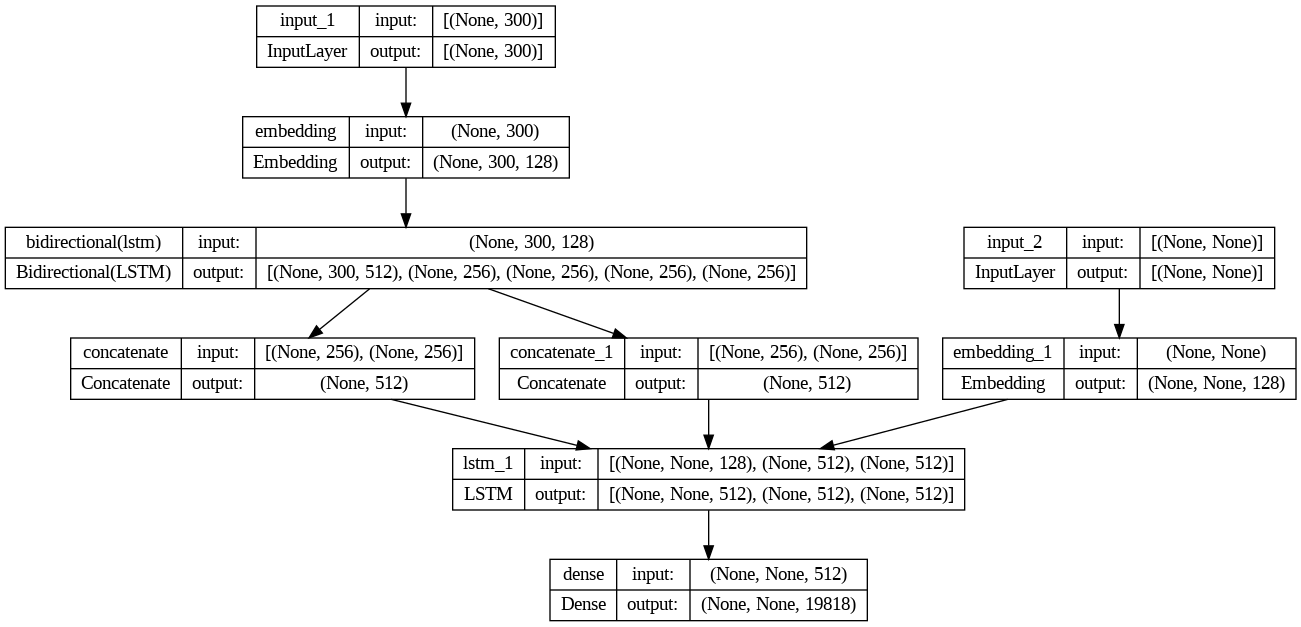

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def create_callbacks(base_path='/model', project_name='lstm-model3'):
    # EarlyStopping callback
    es = EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=2,
        restore_best_weights=False
    )

    # ModelCheckpoint callback
    filename = "saved-model-{epoch:02d}.keras"
    filepath = os.path.join(base_path, project_name, filename)
    mc = ModelCheckpoint(
        filepath,
        monitor='val_loss',
        verbose=0,
        save_best_only=False,
        save_weights_only=False,
        mode='auto',
        save_freq='epoch'
    )

    return [es, mc]

callbacks = create_callbacks(PATH)

# model.fit(..., callbacks=callback

Next is to configure the RMSprop (Root Mean Square Propagation) optimizer, which used for handling noisy and non-stationary of training neural networks.
RMSprop is an adaptive learning rate method, which means it adjusts the learning rate during training.
The rho parameter is a hyperparameter for RMSprop that controls the moving average of the squared gradients.

In [ ]:
LEARNING_RATE=0.001
optimizer = RMSprop(learning_rate=LEARNING_RATE, rho=0.9)

In [ ]:
model.compile(optimizer= optimizer, loss='sparse_categorical_crossentropy')

In [ ]:
BATCH_SIZE = 100
EPOCHS = 50

In [ ]:
y_train_3d = y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:]
y_valid_3d = y_valid.reshape(y_valid.shape[0],y_valid.shape[1], 1)[:,1:]

In [ ]:
history = model.fit([x_train, y_train[:,:-1]],
                    y_train_3d,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=([x_valid,y_valid[:,:-1]], y_valid_3d))

model.save_weights("Model Weights/weights")

Epoch 1/50
306/306 [==============================] - 42s 121ms/step - loss: 3.6878 - val_loss: 3.2777
Epoch 2/50
306/306 [==============================] - 32s 104ms/step - loss: 3.2593 - val_loss: 3.2637
Epoch 3/50
306/306 [==============================] - 30s 97ms/step - loss: 3.2443 - val_loss: 3.2584
Epoch 4/50
306/306 [==============================] - 27s 89ms/step - loss: 3.2328 - val_loss: 3.2451
Epoch 5/50
306/306 [==============================] - 27s 87ms/step - loss: 3.2222 - val_loss: 3.2390
Epoch 6/50
306/306 [==============================] - 27s 87ms/step - loss: 3.2121 - val_loss: 3.2338
Epoch 7/50
306/306 [==============================] - 26s 84ms/step - loss: 3.2039 - val_loss: 3.2294
Epoch 8/50
306/306 [==============================] - 25s 83ms/step - loss: 3.1969 - val_loss: 3.2273
Epoch 9/50
306/306 [==============================] - 25s 83ms/step - loss: 3.1909 - val_loss: 3.2246
Epoch 10/50
306/306 [==============================] - 25s 83ms/step - loss: 3.1

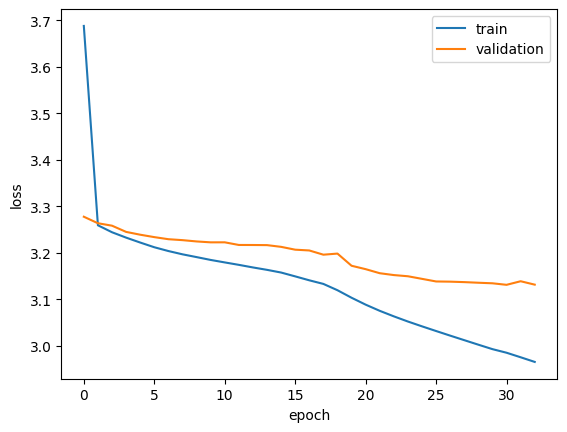

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Model Inference

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [ ]:
encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 128)             6645632   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  [(None, 300, 512),           788480    ['embedding[0][0]']           
 al)                          (None, 256),                                                        
                              (None, 256),                                                        
                              (None, 256),                                                  

 Feed the output and updated states back into the model iteratively to generate an entire sequence word by word.

In [ ]:
decoder_state_input_h = Input(shape=(LATENT_DIM*2,))
decoder_state_input_c = Input(shape=(LATENT_DIM*2,))

# sequence length
# decoder_hidden_state_input = Input(shape=(MAX_CONTENT_LEN,LATENT_DIM*2)) # for attention later?

# decoder_inputs is passed through the decoder_embedding_layer
# to generate decoder_embedding_2, which are the embedded representations of the decoder inputs.
decoder_embedding_2 = decoder_embedding_layer(decoder_inputs)

In [ ]:
# initial_state - LSTM starts with the final states of the encoder (passed as inputs to the decoder model)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding_2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# dense softmax layer
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 128)            2536704   ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 512)]                0         []                            
                                                                                            

In [ ]:
def decode_sequence(input_sequence):
  '''
  This function generates a summary (the output sequence) from a given input sequence using the trained encoder-decoder models
  '''

  encoder_output, encoder_h, encoder_c = encoder_model.predict(input_sequence, verbose=None)

  # Initializing the Target Sequence
  target_sequence = np.zeros((1, 1))

  # First word of target sequence is the start word.
  target_sequence[0, 0] = target_word_index['sostok']

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:

    output_tokens, h, c = decoder_model.predict([target_sequence] + [encoder_output, encoder_h, encoder_c], verbose=None)

    # predict token
    # np.argmax is used to select the token with the highest probability from the decoder's output
    predicted_token_index = np.argmax(output_tokens[0, -1, :])
    predicted_token = reverse_target_word_index[predicted_token_index]

    if predicted_token !='eostok':
        decoded_sentence += ' '+predicted_token

    if predicted_token  == 'eostok'  or len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1):
        stop_condition = True

    target_sequence  = np.zeros((1,1))
    target_sequence[0, 0] = predicted_token_index

    encoder_h, encoder_c = h, c

  return decoded_sentence

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

print(reverse_target_word_index)


{1: 'sostok', 2: 'eostok', 3: 'i', 4: 'people', 5: 'it', 6: 'the', 7: 'like', 8: 'would', 9: 'get', 10: 'you', 11: 'one', 12: 'edit', 13: 'not', 14: 'got', 15: 'us', 16: 'make', 17: 'if', 18: 'time', 19: 'think', 20: 'want', 21: 'good', 22: 'even', 23: 'know', 24: 'much', 25: 'this', 26: 'way', 27: 'shit', 28: 'really', 29: 'also', 30: 'go', 31: 'its', 32: 'could', 33: 'still', 34: 'can', 35: 'bad', 36: 'life', 37: 'going', 38: 'and', 39: 'things', 40: 'work', 41: 'better', 42: 'right', 43: 'years', 44: 'never', 45: 'need', 46: 'guy', 47: 'there', 48: 'see', 49: 'fuck', 50: 'take', 51: 'something', 52: 'dont', 53: 'made', 54: 'someone', 55: 'my', 56: 'friend', 57: 'me', 58: 'back', 59: 'world', 60: 'them', 61: 'lot', 62: 'money', 63: 'a', 64: 'actually', 65: 'girl', 66: 'first', 67: 'use', 68: 'friends', 69: 'everyone', 70: 'many', 71: 'that', 72: 'probably', 73: 'thing', 74: 'day', 75: 'best', 76: 'say', 77: 'wrong', 78: 'without', 79: 'in', 80: 'long', 81: 'fucking', 82: 'may', 83: '

In [ ]:
def sequence_to_content(input_seuqnece):
    sentence = ""
    for i in input_seuqnece:
        if i != 0 :
            sentence = sentence + reverse_source_word_index[i] + " "
    return sentence

In [ ]:
sequence_to_content([10, 148, 1111, 255])

'this is an example '

In [ ]:
def sequence_to_summary(input_seuqnece):
    sentence=''
    for i in input_seuqnece:
        if((i!=0 and i!= target_word_index['sostok']) and i!= target_word_index['eostok']):
            sentence=sentence + reverse_target_word_index[i]+' '
    return sentence

In [ ]:
sequence_to_summary([25, 134, 1017, 639])

'this is an example '

In [ ]:
for i in range(0,5):
    print("Content:",sequence_to_content(x_train[i]))
    print("Original summary:",sequence_to_summary(y_train[i]))
    print("Predicted summary:",decode_sequence(x_train[i].reshape(1,MAX_CONTENT_LEN)))
    print("\n")


Content: this happens games constantly the person expects sent priority cheapest box priority now item sells taking loss since max charge shipping video game items in category means get hits insane category generally video games restricted shipping 
Original summary: sell video games getting shipped anything padded envelope put category hope people search else restricted shipping 
Predicted summary:  if want like it


Content: alright thing i going assume redditors share opinion juana redditors even know differences i pointed out its nearly obvious think is your comment however made abundantly clear article itself tone lawyers account in nutshell said does matter still illegal gave supporting reason be probably agree it 
Original summary: obviously matter still went prison better luck next time 
Predicted summary:  i think i think i think i would rather i would go it


Content: i take first place stupidity thank you flash back years i years old socially frustrated product religious upb

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

for i in range(0, 5):
  # Decode the summary and prediction
  actual_summary = sequence_to_summary(y_train[i])
  predicted_summary = decode_sequence(x_train[i].reshape(1,MAX_CONTENT_LEN))

  scores = scorer.score(predicted_summary,actual_summary)

  print(f"Iteration {i+1}")
  print("Content:",sequence_to_content(x_train[i]))
  print("Original summary:",sequence_to_summary(y_train[i]))
  print("Predicted summary:",decode_sequence(x_train[i].reshape(1,MAX_CONTENT_LEN)))

  # Print ROUGE scores
  print("ROUGE-1 F Score: ", scores['rouge1'].fmeasure)
  print("ROUGE-1 Precision: ", scores['rouge1'].precision)
  print("ROUGE-1 Recall: ", scores['rouge1'].recall)
  print("ROUGE-L F Score: ", scores['rougeL'].fmeasure)
  print("ROUGE-L Precision: ", scores['rougeL'].precision)
  print("ROUGE-L Recall: ", scores['rougeL'].recall)
  print("---------------------------------")


Iteration 1
Content: this happens games constantly the person expects sent priority cheapest box priority now item sells taking loss since max charge shipping video game items in category means get hits insane category generally video games restricted shipping 
Original summary: sell video games getting shipped anything padded envelope put category hope people search else restricted shipping 
Predicted summary:  if want like it
ROUGE-1 F Score:  0.0
ROUGE-1 Precision:  0.0
ROUGE-1 Recall:  0.0
ROUGE-L F Score:  0.0
ROUGE-L Precision:  0.0
ROUGE-L Recall:  0.0
---------------------------------
Iteration 2
Content: alright thing i going assume redditors share opinion juana redditors even know differences i pointed out its nearly obvious think is your comment however made abundantly clear article itself tone lawyers account in nutshell said does matter still illegal gave supporting reason be probably agree it 
Original summary: obviously matter still went prison better luck next time 
Pre

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rougeL_scores = []

# Loop through the validation data
for i in range(0, 1000):
  if i % 100 == 0:
    print(f"Processing sample {i}")
  scores = scorer.score(sequence_to_summary(y_valid[i]), decode_sequence(x_valid[i].reshape(1, MAX_CONTENT_LEN)))
  rouge1_scores.append(scores['rouge1'][1])
  rougeL_scores.append(scores['rougeL'][1])


# Calculate average scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average Rouge-1 Score: ", average_rouge1)
print("Average Rouge-L Score: ", average_rougeL)

# # test: Print individual scores
# for i in range(len(rouge1_scores)):
#     print(f"Sample {i}: Rouge-1: {rouge1_scores[i]}, Rouge-L: {rougeL_scores[i]}")


Processing sample 0
Processing sample 100
Processing sample 200
Processing sample 300
Processing sample 400
Processing sample 500
Processing sample 600
Processing sample 700
Processing sample 800
Processing sample 900
Average Rouge-1 Score:  0.050306368905283894
Average Rouge-L Score:  0.04825010713390094


In [ ]:
for i in range(1001, 2000):
  if i % 100 == 0:
    print(f"Processing sample {i}")
  scores = scorer.score(sequence_to_summary(y_valid[i]), decode_sequence(x_valid[i].reshape(1, MAX_CONTENT_LEN)))
  rouge1_scores.append(scores['rouge1'][1])
  rougeL_scores.append(scores['rougeL'][1])


# Calculate average scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average Rouge-1 Score: ", average_rouge1)
print("Average Rouge-L Score: ", average_rougeL)


Processing sample 1100
Processing sample 1200
Processing sample 1300
Processing sample 1400
Processing sample 1500
Processing sample 1600
Processing sample 1700
Processing sample 1800
Processing sample 1900
Average Rouge-1 Score:  0.05261453103869212
Average Rouge-L Score:  0.050684859143888226


In [ ]:
for i in range(2001, 3000):
  if i % 100 == 0:
    print(f"Processing sample {i}")
  scores = scorer.score(sequence_to_summary(y_valid[i]), decode_sequence(x_valid[i].reshape(1, MAX_CONTENT_LEN)))
  rouge1_scores.append(scores['rouge1'][1])
  rougeL_scores.append(scores['rougeL'][1])


# Calculate average scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average Rouge-1 Score: ", average_rouge1)
print("Average Rouge-L Score: ", average_rougeL)


Processing sample 2100
Processing sample 2200
Processing sample 2300
Processing sample 2400
Processing sample 2500
Processing sample 2600
Processing sample 2700
Processing sample 2800
Processing sample 2900
Average Rouge-1 Score:  0.05131379294129448
Average Rouge-L Score:  0.049596681675916646


In [ ]:
for i in range(3001, 4000):
  if i % 100 == 0:
    print(f"Processing sample {i}")
  scores = scorer.score(sequence_to_summary(y_valid[i]), decode_sequence(x_valid[i].reshape(1, MAX_CONTENT_LEN)))
  rouge1_scores.append(scores['rouge1'][1])
  rougeL_scores.append(scores['rougeL'][1])


# Calculate average scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average Rouge-1 Score: ", average_rouge1)
print("Average Rouge-L Score: ", average_rougeL)


Processing sample 3100
Processing sample 3200
Processing sample 3300
Processing sample 3400
Processing sample 3500
Processing sample 3600
Processing sample 3700
Processing sample 3800
Processing sample 3900
Average Rouge-1 Score:  0.051481458948316836
Average Rouge-L Score:  0.049694429650428244


In [ ]:
for i in range(4001, 5400):
  if i % 100 == 0:
    print(f"Processing sample {i}")
  scores = scorer.score(sequence_to_summary(y_valid[i]), decode_sequence(x_valid[i].reshape(1, MAX_CONTENT_LEN)))
  rouge1_scores.append(scores['rouge1'][1])
  rougeL_scores.append(scores['rougeL'][1])


# Calculate average scores
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("Average Rouge-1 Score: ", average_rouge1)
print("Average Rouge-L Score: ", average_rougeL)

Processing sample 4100
Processing sample 4200
Processing sample 4300
Processing sample 4400
Processing sample 4500
Processing sample 4600
Processing sample 4700
Processing sample 4800
Processing sample 4900
Processing sample 5000
Processing sample 5100
Processing sample 5200
Processing sample 5300
Average Rouge-1 Score:  0.052257227562554985
Average Rouge-L Score:  0.05043497026361683
